# Testing For Corrupted Features

In [ ]:
import os
import numpy as np
import shutil

# === Paths ===
INPUT_DIR = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Features"
BAD_FEATURES_DIR = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Corrupted_Features"
os.makedirs(BAD_FEATURES_DIR, exist_ok=True)

# === Step 1: Detect corrupted files ===
corrupted_files = []

for raaga_folder in os.listdir(INPUT_DIR):
    raaga_path = os.path.join(INPUT_DIR, raaga_folder)
    if not os.path.isdir(raaga_path):
        continue

    for file in os.listdir(raaga_path):
        if file.endswith(".npy"):
            file_path = os.path.join(raaga_path, file)
            try:
                data = np.load(file_path)

                # Check for NaN, Inf, or non-finite values
                if np.isnan(data).any() or np.isinf(data).any() or not np.all(np.isfinite(data)):
                    print(f" Corrupted: {file_path}")
                    corrupted_files.append(file_path)

            except Exception as e:
                print(f" Could not read {file_path}: {e}")
                corrupted_files.append(file_path)

print(f"\n Scan complete. Total corrupted files: {len(corrupted_files)}")

# === Step 2: Move corrupted files to a separate folder ===
for file_path in corrupted_files:
    file_name = os.path.basename(file_path)
    raaga_name = os.path.basename(os.path.dirname(file_path))

    target_subfolder = os.path.join(BAD_FEATURES_DIR, raaga_name)
    os.makedirs(target_subfolder, exist_ok=True)

    # Move the corrupted file
    shutil.move(file_path, os.path.join(target_subfolder, file_name))
    print(f" Moved: {file_name} → {target_subfolder}")


# Dataset Spilt

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:


# === Paths ===
INPUT_DIR = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Features"
OUTPUT_BASE = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Split"
TRAIN_DIR = os.path.join(OUTPUT_BASE, "train")
VAL_DIR = os.path.join(OUTPUT_BASE, "val")
TEST_DIR = os.path.join(OUTPUT_BASE, "test")

# === Create output folders ===
for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(folder, exist_ok=True)

# === Collect all feature files and their labels ===
data = []

for raga in sorted(os.listdir(INPUT_DIR)):
    raga_path = os.path.join(INPUT_DIR, raga)
    if not os.path.isdir(raga_path):
        continue

    for fname in os.listdir(raga_path):
        if fname.endswith(".npy"):
            fpath = os.path.join(raga_path, fname)
            is_augmented = any(x in fname for x in ["pitch", "noise", "stretch"])
            data.append((fpath, raga, is_augmented))

# === Separate original and augmented ===
original_data = [(f, r) for f, r, is_aug in data if not is_aug]
augmented_data = [(f, r) for f, r, is_aug in data if is_aug]

# === Stratified split of original data ===
file_paths = [f for f, r in original_data]
labels = [r for f, r in original_data]

X_trainval, X_test, y_trainval, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === Utility: copy files to split folders ===
def copy_files(file_list, labels, target_dir):
    for src, raga in zip(file_list, labels):
        dest_dir = os.path.join(target_dir, raga)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(src, os.path.join(dest_dir, os.path.basename(src)))

# === Copy files ===
copy_files(X_train, y_train, TRAIN_DIR)
copy_files(X_val, y_val, VAL_DIR)
copy_files(X_test, y_test, TEST_DIR)

# === Optionally: Add augmented data to train only ===
for fpath, raga in augmented_data:
    dest_dir = os.path.join(TRAIN_DIR, raga)
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(fpath, os.path.join(dest_dir, os.path.basename(fpath)))

print("\n Dataset split complete:")
print(f" - Train: {len(os.listdir(TRAIN_DIR))} rāgas")
print(f" - Val:   {len(os.listdir(VAL_DIR))} rāgas")
print(f" - Test:  {len(os.listdir(TEST_DIR))} rāgas")


In [ ]:
import os

# Function to count files in a directory (including subdirectories)
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count the files in train, val, and test directories
train_files_count = count_files_in_directory(TRAIN_DIR)
val_files_count = count_files_in_directory(VAL_DIR)
test_files_count = count_files_in_directory(TEST_DIR)

print(f"Number of files in Train directory: {train_files_count}")
print(f"Number of files in Val directory: {val_files_count}")
print(f"Number of files in Test directory: {test_files_count}")


In [ ]:
Load Features

In [1]:
import numpy as np
import os

# Function to load features and labels from a folder
def load_data_from_directory(split_dir):
    X = []
    y = []
    class_names = sorted(os.listdir(split_dir))  # Assumes each subdir is a class
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for raga in class_names:
        raga_dir = os.path.join(split_dir, raga)
        if not os.path.isdir(raga_dir):
            continue
        for fname in os.listdir(raga_dir):
            if fname.endswith('.npy'):
                fpath = os.path.join(raga_dir, fname)
                features = np.load(fpath)
                X.append(features)
                y.append(label_map[raga])

    return np.array(X), np.array(y), class_names


In [3]:
TRAIN_DIR = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Split\train"
VAL_DIR   = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Split\val"
TEST_DIR  = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Split\test"

X_train, y_train, class_names = load_data_from_directory(TRAIN_DIR)
X_val, y_val, _ = load_data_from_directory(VAL_DIR)
X_test, y_test, _ = load_data_from_directory(TEST_DIR)


# One-hot Encode the Labels

In [6]:
from tensorflow.keras.utils import to_categorical

num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [8]:
print(f"X_train: {X_train.shape}, y_train: {y_train_cat.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val_cat.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test_cat.shape}")


X_train: (21264, 1001, 3), y_train: (21264, 10)
X_val:   (904, 1001, 3), y_val:   (904, 10)
X_test:  (1130, 1001, 3), y_test:  (1130, 10)


# Model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Masking, Multiply, Softmax, Permute, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

# === Custom Attention Layer ===
from tensorflow.keras.layers import Lambda

def attention_block(inputs):
    attention_scores = Dense(1, activation='tanh')(inputs)          # (batch, time, 1)
    attention_scores = Softmax(axis=1)(attention_scores)            # (batch, time, 1)
    weighted = Multiply()([inputs, attention_scores])               # Element-wise multiplication
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)  #  Wrapped as a Keras layer
    return context_vector


# === Build the Model ===
def build_raga_model(input_shape=(1001, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    
    # Mask padded values (if you pad shorter sequences)
    x = Masking(mask_value=0.0)(inputs)

    # CNN Block
    x = Conv1D(64, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # BiLSTM Block
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Attention Block
    x = attention_block(x)

    # Classification Head
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# === Compile the Model ===
model = build_raga_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# === Summary ===
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1001, 3)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 1001, 3)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 1001, 64)     1024        ['masking[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1001, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                   

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# === Callbacks ===
checkpoint_path = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Check"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]


# === Train the model ===
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 2.1554 - accuracy: 0.1971
Epoch 1: val_accuracy improved from -inf to 0.31416, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 155s 217ms/step - loss: 2.1554 - accuracy: 0.1971 - val_loss: 1.9203 - val_accuracy: 0.3142
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 1.9109 - accuracy: 0.3147
Epoch 2: val_accuracy improved from 0.31416 to 0.47235, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 147s 221ms/step - loss: 1.9109 - accuracy: 0.3147 - val_loss: 1.5621 - val_accuracy: 0.4723
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 1.6687 - accuracy: 0.4133
Epoch 3: val_accuracy improved from 0.47235 to 0.58296, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 136s 204ms/step - loss: 1.6687 - accuracy: 0.4133 - val_loss: 1.3041 - val_accuracy: 0.5830
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.4987
Epoch 4: val_accuracy improved from 0.58296 to 0.68473, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 137s 205ms/step - loss: 1.4500 - accuracy: 0.4987 - val_loss: 1.0199 - val_accuracy: 0.6847
Epoch 5/100
665/665 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.5825
Epoch 5: val_accuracy improved from 0.68473 to 0.76438, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 134s 201ms/step - loss: 1.2459 - accuracy: 0.5825 - val_loss: 0.7823 - val_accuracy: 0.7644
Epoch 6/100
665/665 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.6307
Epoch 6: val_accuracy improved from 0.76438 to 0.76549, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 119s 178ms/step - loss: 1.0996 - accuracy: 0.6307 - val_loss: 0.7376 - val_accuracy: 0.7655
Epoch 7/100
665/665 [==============================] - ETA: 0s - loss: 0.9506 - accuracy: 0.6806
Epoch 7: val_accuracy improved from 0.76549 to 0.79978, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 124s 187ms/step - loss: 0.9506 - accuracy: 0.6806 - val_loss: 0.6144 - val_accuracy: 0.7998
Epoch 8/100
665/665 [==============================] - ETA: 0s - loss: 0.8799 - accuracy: 0.7070
Epoch 8: val_accuracy improved from 0.79978 to 0.84624, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 119s 179ms/step - loss: 0.8799 - accuracy: 0.7070 - val_loss: 0.5040 - val_accuracy: 0.8462
Epoch 9/100
665/665 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.7482
Epoch 9: val_accuracy improved from 0.84624 to 0.87279, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 137s 206ms/step - loss: 0.7573 - accuracy: 0.7482 - val_loss: 0.4398 - val_accuracy: 0.8728
Epoch 10/100
665/665 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.7718
Epoch 10: val_accuracy improved from 0.87279 to 0.88274, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 153s 231ms/step - loss: 0.6910 - accuracy: 0.7718 - val_loss: 0.3684 - val_accuracy: 0.8827
Epoch 11/100
665/665 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.7768
Epoch 11: val_accuracy did not improve from 0.88274
665/665 [==============================] - 118s 177ms/step - loss: 0.6730 - accuracy: 0.7768 - val_loss: 0.3763 - val_accuracy: 0.8816
Epoch 12/100
665/665 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.8067
Epoch 12: val_accuracy improved from 0.88274 to 0.90708, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 137s 206ms/step - loss: 0.5872 - accuracy: 0.8067 - val_loss: 0.3122 - val_accuracy: 0.9071
Epoch 13/100
665/665 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.8153
Epoch 13: val_accuracy improved from 0.90708 to 0.91040, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 139s 209ms/step - loss: 0.5541 - accuracy: 0.8153 - val_loss: 0.2971 - val_accuracy: 0.9104
Epoch 14/100
665/665 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.7935
Epoch 14: val_accuracy did not improve from 0.91040
665/665 [==============================] - 106s 159ms/step - loss: 0.6316 - accuracy: 0.7935 - val_loss: 1.0162 - val_accuracy: 0.6571
Epoch 15/100
665/665 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.7377
Epoch 15: val_accuracy did not improve from 0.91040
665/665 [==============================] - 100s 151ms/step - loss: 0.7791 - accuracy: 0.7377 - val_loss: 0.3610 - val_accuracy: 0.8861
Epoch 16/100
665/665 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.8070
Epoch 16: val_accuracy did not improve from 0.91040
665/665 [==============================] - 103s 154ms/step - loss: 0.5791 - accuracy: 0.8070 - val_loss: 0.3024 - val_accuracy: 0.9049
Epoch 17/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 140s 210ms/step - loss: 0.5340 - accuracy: 0.8204 - val_loss: 0.2728 - val_accuracy: 0.9226
Epoch 19/100
665/665 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8464
Epoch 19: val_accuracy improved from 0.92257 to 0.93363, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 148s 222ms/step - loss: 0.4591 - accuracy: 0.8464 - val_loss: 0.2338 - val_accuracy: 0.9336
Epoch 20/100
665/665 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8583
Epoch 20: val_accuracy improved from 0.93363 to 0.93473, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 131s 197ms/step - loss: 0.4237 - accuracy: 0.8583 - val_loss: 0.2195 - val_accuracy: 0.9347
Epoch 21/100
665/665 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8716
Epoch 21: val_accuracy improved from 0.93473 to 0.94137, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 135s 203ms/step - loss: 0.3915 - accuracy: 0.8716 - val_loss: 0.1914 - val_accuracy: 0.9414
Epoch 22/100
665/665 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8792
Epoch 22: val_accuracy did not improve from 0.94137
665/665 [==============================] - 107s 161ms/step - loss: 0.3662 - accuracy: 0.8792 - val_loss: 0.1885 - val_accuracy: 0.9392
Epoch 23/100
665/665 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8809
Epoch 23: val_accuracy improved from 0.94137 to 0.94690, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 155s 232ms/step - loss: 0.3630 - accuracy: 0.8809 - val_loss: 0.1883 - val_accuracy: 0.9469
Epoch 24/100
665/665 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8957
Epoch 24: val_accuracy improved from 0.94690 to 0.94801, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 189s 284ms/step - loss: 0.3183 - accuracy: 0.8957 - val_loss: 0.1658 - val_accuracy: 0.9480
Epoch 25/100
665/665 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8960
Epoch 25: val_accuracy did not improve from 0.94801
665/665 [==============================] - 168s 253ms/step - loss: 0.3099 - accuracy: 0.8960 - val_loss: 0.1575 - val_accuracy: 0.9425
Epoch 26/100
665/665 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.9010
Epoch 26: val_accuracy improved from 0.94801 to 0.96018, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 192s 288ms/step - loss: 0.2996 - accuracy: 0.9010 - val_loss: 0.1228 - val_accuracy: 0.9602
Epoch 27/100
665/665 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9048
Epoch 27: val_accuracy did not improve from 0.96018
665/665 [==============================] - 161s 242ms/step - loss: 0.2921 - accuracy: 0.9048 - val_loss: 0.1593 - val_accuracy: 0.9447
Epoch 28/100
665/665 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.9044
Epoch 28: val_accuracy did not improve from 0.96018
665/665 [==============================] - 161s 243ms/step - loss: 0.2869 - accuracy: 0.9044 - val_loss: 0.1474 - val_accuracy: 0.9491
Epoch 29/100
665/665 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8649
Epoch 29: val_accuracy did not improve from 0.96018
665/665 [==============================] - 164s 247ms/step - loss: 0.4133 - accuracy: 0.8649 - val_loss: 0.2207 - val_accuracy: 0.9259
Epoch 30/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 198s 297ms/step - loss: 0.2746 - accuracy: 0.9073 - val_loss: 0.1051 - val_accuracy: 0.9690
Epoch 33/100
665/665 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.9025
Epoch 33: val_accuracy did not improve from 0.96903
665/665 [==============================] - 176s 264ms/step - loss: 0.2926 - accuracy: 0.9025 - val_loss: 0.1392 - val_accuracy: 0.9580
Epoch 34/100
665/665 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.9087
Epoch 34: val_accuracy did not improve from 0.96903
665/665 [==============================] - 164s 246ms/step - loss: 0.2745 - accuracy: 0.9087 - val_loss: 0.1642 - val_accuracy: 0.9436
Epoch 35/100
665/665 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9190
Epoch 35: val_accuracy did not improve from 0.96903
665/665 [==============================] - 179s 269ms/step - loss: 0.2423 - accuracy: 0.9190 - val_loss: 0.1569 - val_accuracy: 0.9524
Epoch 36/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 223s 335ms/step - loss: 0.2253 - accuracy: 0.9241 - val_loss: 0.0995 - val_accuracy: 0.9712
Epoch 38/100
665/665 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9272
Epoch 38: val_accuracy improved from 0.97124 to 0.97235, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 194s 292ms/step - loss: 0.2196 - accuracy: 0.9272 - val_loss: 0.0869 - val_accuracy: 0.9723
Epoch 39/100
665/665 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9331
Epoch 39: val_accuracy did not improve from 0.97235
665/665 [==============================] - 111s 167ms/step - loss: 0.1998 - accuracy: 0.9331 - val_loss: 0.1264 - val_accuracy: 0.9602
Epoch 40/100
665/665 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9386
Epoch 40: val_accuracy did not improve from 0.97235
665/665 [==============================] - 115s 174ms/step - loss: 0.1847 - accuracy: 0.9386 - val_loss: 0.0857 - val_accuracy: 0.9701
Epoch 41/100
665/665 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9116
Epoch 41: val_accuracy did not improve from 0.97235
665/665 [==============================] - 104s 156ms/step - loss: 0.2691 - accuracy: 0.9116 - val_loss: 0.1266 - val_accuracy: 0.9580
Epoch 42/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 144s 217ms/step - loss: 0.1682 - accuracy: 0.9434 - val_loss: 0.0791 - val_accuracy: 0.9779
Epoch 47/100
665/665 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9420
Epoch 47: val_accuracy did not improve from 0.97788
665/665 [==============================] - 115s 173ms/step - loss: 0.1728 - accuracy: 0.9420 - val_loss: 0.0943 - val_accuracy: 0.9690
Epoch 48/100
665/665 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9509
Epoch 48: val_accuracy did not improve from 0.97788
665/665 [==============================] - 108s 163ms/step - loss: 0.1499 - accuracy: 0.9509 - val_loss: 0.0888 - val_accuracy: 0.9712
Epoch 49/100
665/665 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9461
Epoch 49: val_accuracy did not improve from 0.97788
665/665 [==============================] - 110s 166ms/step - loss: 0.1605 - accuracy: 0.9461 - val_loss: 0.0622 - val_accuracy: 0.9779
Epoch 50/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 142s 214ms/step - loss: 0.1487 - accuracy: 0.9505 - val_loss: 0.0537 - val_accuracy: 0.9856
Epoch 51/100
665/665 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9485
Epoch 51: val_accuracy did not improve from 0.98562
665/665 [==============================] - 123s 185ms/step - loss: 0.1593 - accuracy: 0.9485 - val_loss: 0.0826 - val_accuracy: 0.9746
Epoch 52/100
665/665 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9540
Epoch 52: val_accuracy did not improve from 0.98562
665/665 [==============================] - 119s 179ms/step - loss: 0.1388 - accuracy: 0.9540 - val_loss: 0.0749 - val_accuracy: 0.9768
Epoch 53/100
665/665 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9577
Epoch 53: val_accuracy did not improve from 0.98562
665/665 [==============================] - 120s 180ms/step - loss: 0.1280 - accuracy: 0.9577 - val_loss: 0.0775 - val_accuracy: 0.9723
Epoch 54/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 158s 238ms/step - loss: 0.1052 - accuracy: 0.9644 - val_loss: 0.0346 - val_accuracy: 0.9878
Epoch 59/100
665/665 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9608
Epoch 59: val_accuracy did not improve from 0.98783
665/665 [==============================] - 125s 188ms/step - loss: 0.1186 - accuracy: 0.9608 - val_loss: 0.0506 - val_accuracy: 0.9867
Epoch 60/100
665/665 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9600
Epoch 60: val_accuracy did not improve from 0.98783
665/665 [==============================] - 106s 160ms/step - loss: 0.1211 - accuracy: 0.9600 - val_loss: 0.0397 - val_accuracy: 0.9867
Epoch 61/100
665/665 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9593
Epoch 61: val_accuracy improved from 0.98783 to 0.99004, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 151s 228ms/step - loss: 0.1167 - accuracy: 0.9593 - val_loss: 0.0395 - val_accuracy: 0.9900
Epoch 62/100
665/665 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9662
Epoch 62: val_accuracy did not improve from 0.99004
665/665 [==============================] - 109s 163ms/step - loss: 0.1009 - accuracy: 0.9662 - val_loss: 0.0567 - val_accuracy: 0.9845
Epoch 63/100
665/665 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9673
Epoch 63: val_accuracy improved from 0.99004 to 0.99115, saving model to C:\College\Subjects\Sem 6\Speech Processing\Project\Check


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 139s 210ms/step - loss: 0.0991 - accuracy: 0.9673 - val_loss: 0.0291 - val_accuracy: 0.9912
Epoch 64/100
665/665 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9632
Epoch 64: val_accuracy did not improve from 0.99115
665/665 [==============================] - 111s 167ms/step - loss: 0.1079 - accuracy: 0.9632 - val_loss: 0.0400 - val_accuracy: 0.9845
Epoch 65/100
665/665 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9670
Epoch 65: val_accuracy did not improve from 0.99115
665/665 [==============================] - 113s 170ms/step - loss: 0.0965 - accuracy: 0.9670 - val_loss: 0.0609 - val_accuracy: 0.9812
Epoch 66/100
665/665 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9680
Epoch 66: val_accuracy did not improve from 0.99115
665/665 [==============================] - 113s 169ms/step - loss: 0.0965 - accuracy: 0.9680 - val_loss: 0.0720 - val_accuracy: 0.9779
Epoch 67/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 140s 211ms/step - loss: 0.0840 - accuracy: 0.9723 - val_loss: 0.0242 - val_accuracy: 0.9934
Epoch 71/100
665/665 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9415
Epoch 71: val_accuracy did not improve from 0.99336
665/665 [==============================] - 124s 186ms/step - loss: 0.1867 - accuracy: 0.9415 - val_loss: 0.0643 - val_accuracy: 0.9834
Epoch 72/100
665/665 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9671
Epoch 72: val_accuracy did not improve from 0.99336
665/665 [==============================] - 121s 181ms/step - loss: 0.1015 - accuracy: 0.9671 - val_loss: 0.0387 - val_accuracy: 0.9878
Epoch 73/100
665/665 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9724
Epoch 73: val_accuracy did not improve from 0.99336
665/665 [==============================] - 128s 192ms/step - loss: 0.0811 - accuracy: 0.9724 - val_loss: 0.0398 - val_accuracy: 0.9889
Epoch 74/1

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 141s 212ms/step - loss: 0.0663 - accuracy: 0.9785 - val_loss: 0.0231 - val_accuracy: 0.9945
Epoch 90/100
665/665 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9778
Epoch 90: val_accuracy did not improve from 0.99447
665/665 [==============================] - 102s 153ms/step - loss: 0.0651 - accuracy: 0.9778 - val_loss: 0.0295 - val_accuracy: 0.9912
Epoch 91/100
665/665 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9748
Epoch 91: val_accuracy did not improve from 0.99447
665/665 [==============================] - 108s 162ms/step - loss: 0.0774 - accuracy: 0.9748 - val_loss: 0.0218 - val_accuracy: 0.9923
Epoch 92/100
665/665 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9813
Epoch 92: val_accuracy did not improve from 0.99447
665/665 [==============================] - 99s 148ms/step - loss: 0.0617 - accuracy: 0.9813 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 93/10

INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


INFO:tensorflow:Assets written to: C:\College\Subjects\Sem 6\Speech Processing\Project\Check\assets


665/665 [==============================] - 138s 208ms/step - loss: 0.0608 - accuracy: 0.9797 - val_loss: 0.0199 - val_accuracy: 0.9956


# Results

In [16]:
# Load test data

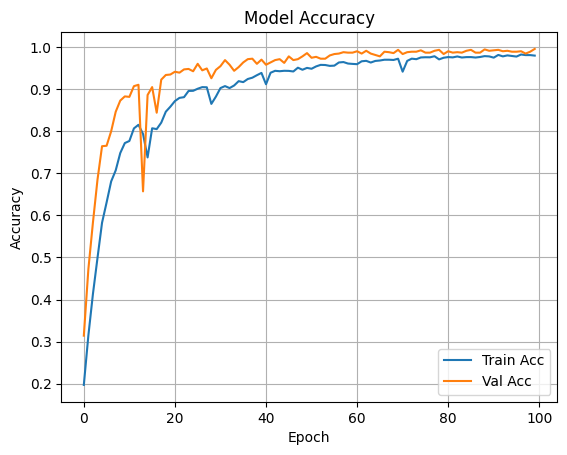

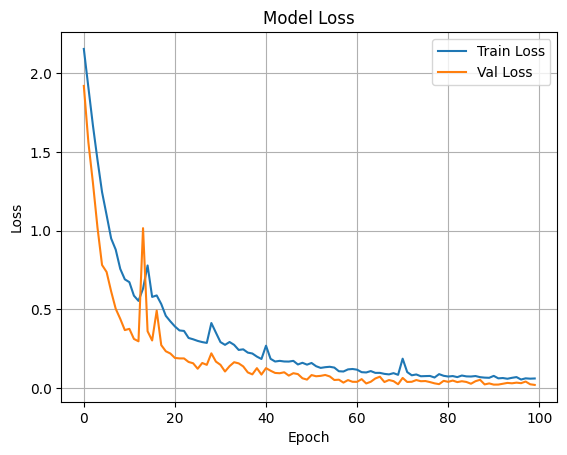

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [21]:
import os
import numpy as np

# === Step 1: Load test features and labels ===
def load_data_from_directory(split_dir, class_names):
    X = []
    y = []
    label_map = {name: idx for idx, name in enumerate(class_names)}
    
    for raga in class_names:
        raga_dir = os.path.join(split_dir, raga)
        if not os.path.isdir(raga_dir):
            continue
        
        for fname in os.listdir(raga_dir):
            if fname.endswith('.npy'):
                fpath = os.path.join(raga_dir, fname)
                X.append(np.load(fpath))
                y.append(label_map[raga])
    
    return np.array(X), np.array(y)

# === Define paths ===
TEST_DIR = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Dataset\Split\test"

# === Get class names from folder names ===
class_names = sorted(os.listdir(TEST_DIR))  # e.g., ['Mohanam', 'Neelambari', ...]

# === Load test data ===
X_test, y_test = load_data_from_directory(TEST_DIR, class_names)


In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# === Step 2: Load the trained model ===
MODEL_PATH = r"C:\College\Subjects\Sem 6\Speech Processing\Project\Check"
model = load_model(MODEL_PATH)

# === One-hot encode the test labels ===
num_classes = len(class_names)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# === Evaluate on test set ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")


36/36 [==============================] - 6s 83ms/step - loss: 0.0451 - accuracy: 0.9876

 Test Accuracy: 0.9876
 Test Loss: 0.0451


In [31]:
from sklearn.metrics import classification_report

# === Predict class indices ===
y_pred = np.argmax(model.predict(X_test), axis=1)

# === Print classification report ===
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


36/36 [==============================] - 4s 65ms/step

 Classification Report:

                  precision    recall  f1-score   support

  Aanda bhairavi       0.98      1.00      0.99       108
  Darbari Kanada       0.98      0.97      0.98       116
     Hamsadhwani       0.98      1.00      0.99       120
         Kalyani       0.99      0.99      0.99       112
  Kharaharapriya       0.98      0.99      0.99       120
 Mayamalavagowla       0.98      1.00      0.99       114
         Mohanam       1.00      0.98      0.99       113
      Neelambari       0.98      0.98      0.98       122
Shankarabharanam       0.99      0.98      0.98        95
           Thodi       1.00      0.97      0.99       110

        accuracy                           0.99      1130
       macro avg       0.99      0.99      0.99      1130
    weighted avg       0.99      0.99      0.99      1130



C:\Users\knlak\AppData\Local\Temp\ipykernel_1960\575834734.py:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\College\AIE\envs\gpu_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


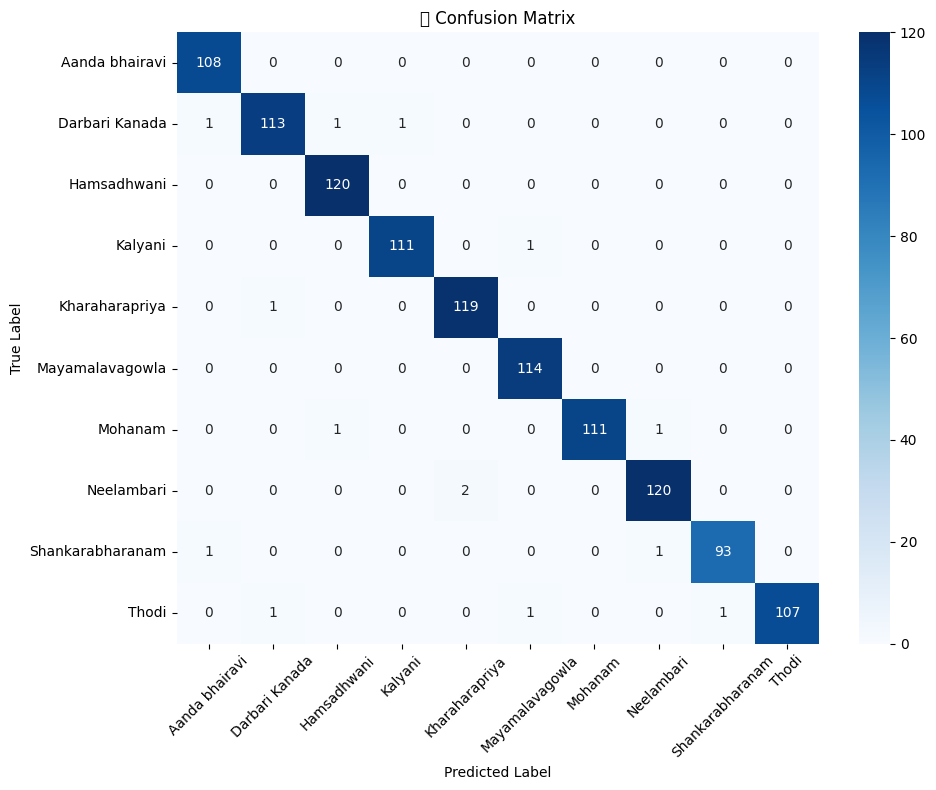

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 4: Compute confusion matrix ===
cm = confusion_matrix(y_test, y_pred) 
# === Plot confusion matrix heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📉 Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
